In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pgmpy.models import BayesianModel

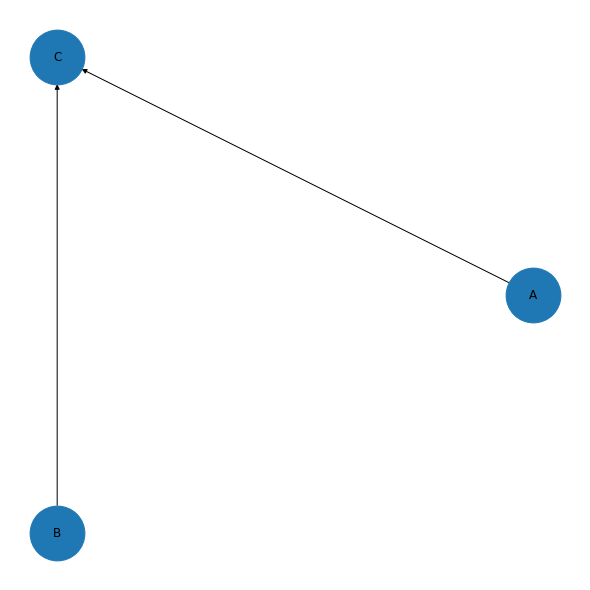

In [2]:
model=BayesianModel([('A','C'),('B','C') ])
import networkx as nx
import matplotlib.pyplot as plt 

G = nx.MultiDiGraph()
G.add_edges_from(model.edges())

plt.figure(figsize=(8,8))
#nx.draw_networkx(G,node_size=3000)
nx.draw_circular(G,node_size=3000, with_labels=True)

In [3]:
p_C_if_A=0.05
p_C_if_B=0.3

#задаем руками. осторожно, чтобы все вероятности были больше 0
p_A=0.05
p_B=0.01

p_CA=p_A*p_C_if_A
print(f'P(CA)={p_CA}')
p_CB=p_B*p_C_if_B
print(f'P(CB)={p_CB}')

#задаем руками. Осторожно, чтобы все вероятности были больше 0.
p_C_if_AB=0.9
p_C_if_notAnotB=0.0

p_CAB=p_A*p_B*p_C_if_AB
print(f'P(CAB)={p_CAB}')
p_CAnotB=p_CA-p_CAB
print(f'P(CAnotB)={p_CAnotB}')
p_CnotAB=p_CB-p_CAB
print(f'P(CnotAB)={p_CnotAB}')
p_CnotAnotB=(1-p_A)*(1-p_B)*p_C_if_notAnotB
print(f'P(CnotAnotB)={p_CnotAnotB}')

p_C_if_AnotB=p_CAnotB/(p_A*(1-p_B))
p_C_if_notAB=p_CnotAB/(p_B*(1-p_A))

#p_C0=[1-p_C_if_notAnotB,1-p_C_if_notAB,1-p_C_if_AnotB,1-p_C_if_AB]
p_C1=np.array([p_C_if_notAnotB,p_C_if_notAB,p_C_if_AnotB,p_C_if_AB])
p_C0=1.0-p_C1

P(CA)=0.0025000000000000005
P(CB)=0.003
P(CAB)=0.00045000000000000004
P(CAnotB)=0.0020500000000000006
P(CnotAB)=0.00255
P(CnotAnotB)=0.0


In [4]:
# задаем распределение вероятностей
from pgmpy.factors.discrete import TabularCPD

cpd_A = TabularCPD(variable='A', variable_card=2, values=[[1-p_A], [p_A]])

cpd_B = TabularCPD(variable='B', variable_card=2, values=[[1-p_B], [p_B]])

cpd_C = TabularCPD(variable='C', variable_card=2, evidence=['A','B'],\
                  values=np.array([p_C0,p_C1]), evidence_card=[2,2])
print(cpd_C)

+------+------+---------------------+----------------------+---------------------+
| A    | A(0) | A(0)                | A(1)                 | A(1)                |
+------+------+---------------------+----------------------+---------------------+
| B    | B(0) | B(1)                | B(0)                 | B(1)                |
+------+------+---------------------+----------------------+---------------------+
| C(0) | 1.0  | 0.7315789473684211  | 0.9585858585858585   | 0.09999999999999998 |
+------+------+---------------------+----------------------+---------------------+
| C(1) | 0.0  | 0.26842105263157895 | 0.041414141414141424 | 0.9                 |
+------+------+---------------------+----------------------+---------------------+


In [5]:
#добавляем распределение в сеть
model.add_cpds(cpd_A,cpd_B,cpd_C)
model.check_model() #проверить модель на ошибки

True

In [6]:
#показать пары независимых переменных
model.get_independencies()

(A _|_ B)
(B _|_ A)

In [7]:
from pgmpy.inference import VariableElimination
infer=VariableElimination(model)
#вывод совместного распределения.
print(infer.query(['A','B','C']) )

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+------+------+------+--------------+
| B    | A    | C    |   phi(B,A,C) |
+======+======+======+==============+
| B(0) | A(0) | C(0) |       0.9405 |
+------+------+------+--------------+
| B(0) | A(0) | C(1) |       0.0000 |
+------+------+------+--------------+
| B(0) | A(1) | C(0) |       0.0474 |
+------+------+------+--------------+
| B(0) | A(1) | C(1) |       0.0021 |
+------+------+------+--------------+
| B(1) | A(0) | C(0) |       0.0070 |
+------+------+------+--------------+
| B(1) | A(0) | C(1) |       0.0025 |
+------+------+------+--------------+
| B(1) | A(1) | C(0) |       0.0000 |
+------+------+------+--------------+
| B(1) | A(1) | C(1) |       0.0005 |
+------+------+------+--------------+


In [14]:
#вероятности состояний 0,1 при условии C=1
inference_B_if_C=infer.query(['B'],evidence={'C':1})
pd.DataFrame(columns=inference_B_if_C.state_names,\
             data=inference_B_if_C.values)


Finding Elimination Order: :   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Eliminating: A: 100%|██████████| 1/1 [00:00<00:00, 242.73it/s]


,B
0,0.405941
1,0.594059
